# Welcome to the Self-Supervised Learning Project!
In this project, we're going to implement the [SimCLR paper](https://arxiv.org/pdf/2002.05709.pdf) on the [BDD 100K dataset](https://bdd-data.berkeley.edu/) (a self-driving car dataset); and this using the [lightly AI Library](https://github.com/lightly-ai/lightly/blob/master/lightly/), a library for self-supervised learning in Python and compatible with PyTorch. A few things before you start:
1. Make sure you're on GPU, we're going to do some Deep Learning training
2. There is no support video for this code, so make sure to read the comments from your SSL Playbook to make sure you understand everything.
3. Good luck! 🙃

### Imports





In [1]:
# basic imports
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##  1 - Data (BDD100k)

- A Diverse Driving Dataset for heterogenous Multi Task learning
- It has labeled annotations for 1000 hours videos, 10 tasks like Object Detection, Semantic Segmentation, Panoptic Segmentation, Instance Segmentation, Drivable Area estimation etc

In [2]:
#!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/bdd100k.zip && unzip bdd100k.zip

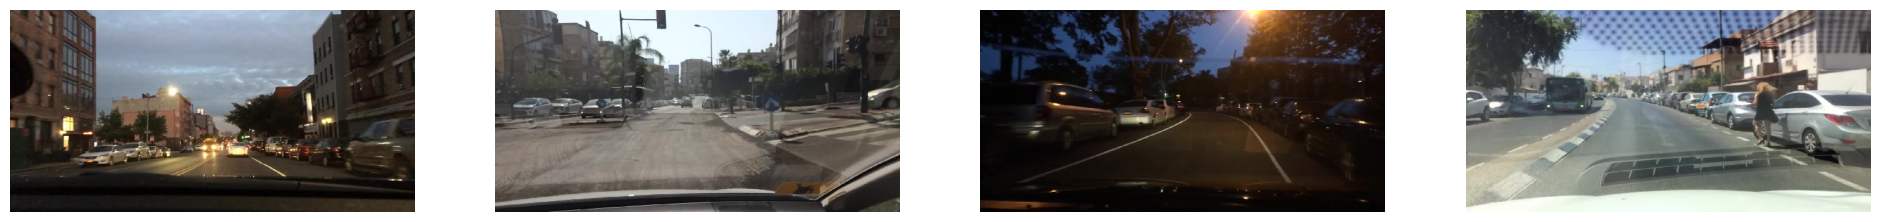

In [3]:
dataDir = 'images_320_640'
filePaths = sorted([os.path.join(dataDir, x) for x in os.listdir(dataDir)])

from PIL import Image

fig, axes = plt.subplots(1,4, figsize= (24, 12))
for ax in axes.flatten():
    path = filePaths[np.random.randint(0, len(filePaths))]
    image = Image.open(path).convert('RGB')
    ax.imshow(image)
    ax.axis('off')

plt.show()

One thing to note is images are **not object-centered**, from different viewpoints, unlike standard datasets like ImageNet. Now that we've explored our data, we'll get more 'PyTorch friendly' and create a Dataset object, as well as a PyTorch Dataloader.

In [4]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader

class CLRDataset(Dataset):
    def __init__(self, rootDir, tf):
        self.rootDir = rootDir
        self.filePaths =  sorted([os.path.join(self.rootDir, x) for x in os.listdir(self.rootDir)])
        self.tf = tf

    def __len__(self):
        return len(self.filePaths)

    def __getitem__(self, index):
        # read source image and convert to RGB
        path = self.filePaths[index]
        with open(path, "rb") as f:
            image = Image.open(f)
            image.convert("RGB")

        if self.tf is not None:
            image = self.tf(image)
        return image, path

- Now, we need to define the transformations for our images. In contrastive learning, we typically create multiple views of same scene and ask the model to differentiate b/w the same scene and different one as positive and negative samples. **Data augmentations play a key role**
- Specifically, we'll be using the transformations used in [SimCLR1](https://arxiv.org/abs/2002.05709) and [SimCLR2](https://arxiv.org/abs/2006.10029)
- Augmentaions used in SimCLR method are as follows:
    - Random resized crop
    - Random horizontal flip
    - Color jitter
    - Random gray scale
    - Gaussian blur
    - ImageNet normalization
    
**lightly** has already implemented a pytorch-friendly class of the above transformations. We can find similar implementaions for popular models in [lighlty transforms](https://github.com/lightly-ai/lightly/tree/master/lightly/transforms)

In [5]:
import torchvision
from lightly import transforms as lightly_transforms

input_size = 128
train_transform = lightly_transforms.SimCLRTransform(
                input_size=input_size, min_scale=0.25, rr_prob=0.5, rr_degrees=(-10,10))
train_dataset = CLRDataset(rootDir=dataDir, tf=train_transform)

We'll visualize augmentations applied on some of the samples

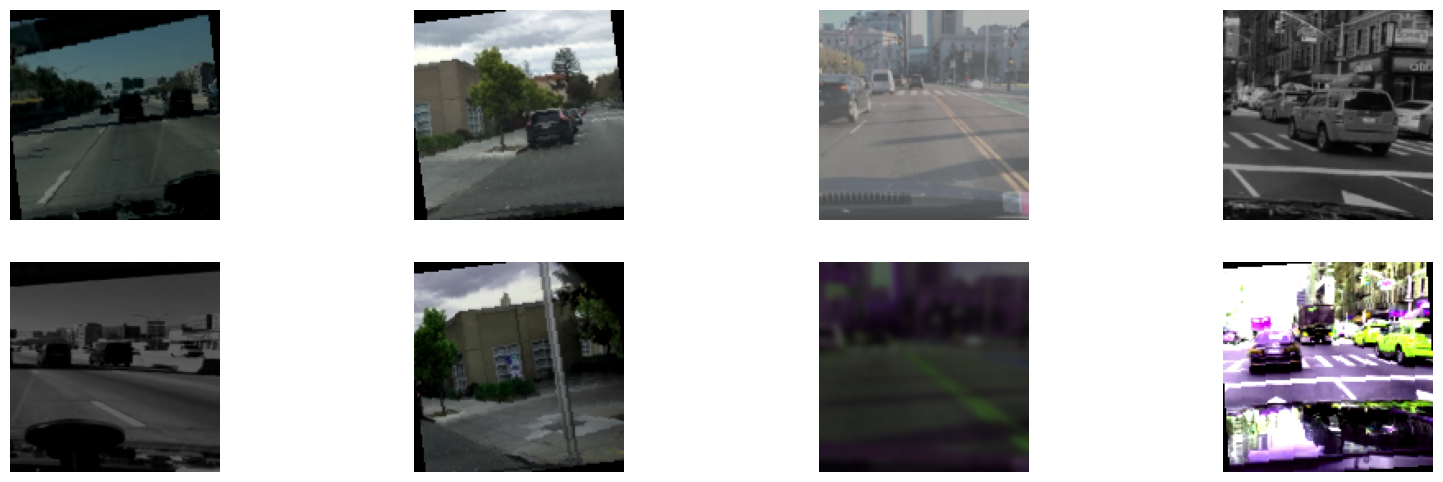

In [6]:
# when using torch datasets we defined earlier, the output image is normalized.
# So we're defining an inverse transformation to transform to normal RGB format
inverse_transform = torchvision.transforms.Compose([
        torchvision.transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
    ])

def invert_normalize(inputImage):
    return inverse_transform(inputImage).permute(1, 2, 0).cpu().detach().numpy()

num_samples = 4
fig, axes = plt.subplots(2, num_samples, figsize= (20, 6))
for i in range(num_samples):
    (img_view1, img_view2), _ = train_dataset[np.random.randint(0, len(train_dataset))]

    # inverse normalization and plot view1
    img_view1 = invert_normalize(img_view1)
    axes[0, i].imshow(img_view1)
    axes[0, i].axis('off')

    # inverse normalization and plot view2
    img_view2 = invert_normalize(img_view2)
    axes[1, i].imshow(img_view2)
    axes[1, i].axis('off')


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=2)

## 2 - Model (SimCLR)
The model we'll use is a Resnet50 backbone + SimCLR Projection head

In [8]:
import torch
import torch.nn as nn
from lightly.models.modules.heads import SimCLRProjectionHead

class SimCLRModel(nn.Module):
    def __init__(self):
        super(SimCLRModel, self).__init__()
        # create a ResNet backbone and remove the classification head
        # The dilation parameters are given, as backbone will be reused with deeplabv3+ model
        backbone = torchvision.models.resnet50(pretrained=True, replace_stride_with_dilation =[False, True, True])
        self.initial = nn.Sequential(*list(backbone.children())[:4])
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        self.avgpool = backbone.avgpool

        hidden_dim = backbone.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

    def backbone_forward(self, x):
        # Pass input through Backbone layers
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def forward(self, x):
        x = self.backbone_forward(x)
        x = self.avgpool(x).flatten(start_dim=1)
        #print(f'Avgpool output ={x.shape}')
        return self.projection_head(x)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLRModel()
model.to(device);

/home/brian/miniconda3/envs/demo/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/brian/miniconda3/envs/demo/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
randomInput = torch.Tensor(32,3,128,128).to(device);
output = model(randomInput)
print(output.shape)  # each sample is compressed / projected to 128 dimensional feature vector

torch.Size([32, 128])


## 3 - Training Loop (Self-Supervised Contrastive Learning)

In [11]:
from lightly.loss import NTXentLoss
# reference : https://docs.lightly.ai/self-supervised-learning/lightly.loss.html
# Contrastive Cross Entropy Loss as described in SimCLR paper
criterion = NTXentLoss()

# MODEL HYPERPARAMETERS
N_EPOCHS = 20
MAX_LR = 6e-2
MODEL_NAME = 'SimCLR_resnet50_BDD100k'

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts

# create model, optimizer, lr_scheduler
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0 = int(len(train_dataloader) * float(N_EPOCHS)/10), eta_min=3e-4)

In [12]:
# We monitor std.dev of the feature representations to see if model faces
# feature-collapse, where model predicts same output for any input image
# If std.dev is 0, then outputs have collapsed to constant vector
# reference: https://arxiv.org/abs/2011.10566

from lightly.utils.debug import std_of_l2_normalized
from tqdm import tqdm

model.to(device); # move model to device

train_losses = []
std_devs = []
min_val_loss = np.inf

for epoch in range(N_EPOCHS):
    epoch_train_loss = 0.0
    epoch_std_devs = 0.0

    with tqdm(train_dataloader, unit="batch") as tepoch:
        for (image_view1, image_view2), _ in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            # pass both views to model, calculate Contrastive loss
            image_view1, image_view2 = image_view1.to(device), image_view2.to(device)
            z0 = model(image_view1)
            z1 = model(image_view2)
            loss = criterion(z0, z1)

            # log values
            epoch_train_loss += loss.item()
            std_dev = std_of_l2_normalized(z1).item()
            epoch_std_devs += std_dev

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

            tepoch.set_postfix(loss=loss.item(), std_dev=std_dev)

    last_epoch_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(last_epoch_loss)
    std_devs.append(epoch_std_devs / len(train_dataloader))

    # save model if loss has decreased
    if last_epoch_loss <= min_val_loss:
        min_val_loss = last_epoch_loss
        torch.save(model.state_dict(), f"{MODEL_NAME}_{N_EPOCHS}ep.pt")

  0%|          | 0/53 [00:00<?, ?batch/s]

Epoch 19: 100%|██████████| 53/53 [00:41<00:00,  1.27batch/s, loss=4.05, std_dev=0.0708]


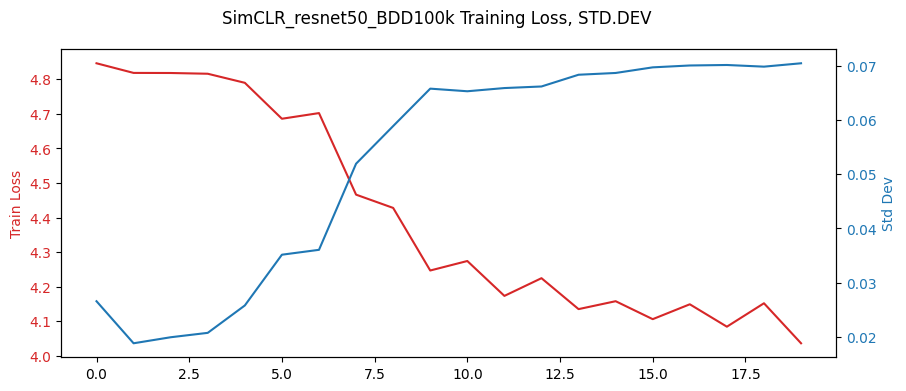

In [13]:
# visualize losses, std.devs
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.set_ylabel('Train Loss', color='tab:red')
ax1.plot(np.arange(N_EPOCHS), train_losses, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Std Dev', color='tab:blue')
ax2.plot(np.arange(N_EPOCHS), std_devs, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.suptitle(f'{MODEL_NAME} Training Loss, STD.DEV')
plt.show()

## 4 - Evaluation using K-Nearest Neighbours
- As there are no labels, we'll evaluate the models using **k Nearest Neighbours**, one of the popular methods to evaluate Self-supervised models. We'll define a test dataset on same directory, but without any of the augmentations / transforms.

In [14]:
# We'll define a test transform too, without any of the augmentations
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean= [0.485, 0.456, 0.406],  # imagenet mean
            std= [0.229, 0.224, 0.225],   # imagenet std.dev
        ),
    ]
)

test_dataset = CLRDataset(rootDir=dataDir, tf=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False, num_workers=2)

In [15]:
# Load from pretrained model
model.load_state_dict(torch.load(f"SimCLR_resnet50_BDD100k_3ep.pt", map_location=device))

/tmp/ipykernel_338730/2383953949.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"SimCLR_resnet50_BDD100k_3ep.pt", map_location=device)

<All keys matched successfully>

### Generate Embeddings for the entire dataset

In [16]:
from sklearn.preprocessing import normalize

def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """
    embeddings = []
    filenames = []
    with torch.no_grad():
        for img,fnames in tqdm(dataloader):
            img = img.to(device)
            emb = model.avgpool(model.backbone_forward(img)).flatten(start_dim=1)
            embeddings.append(emb.detach().cpu().numpy())
            filenames.extend(fnames)

    embeddings = np.concatenate(embeddings, axis=0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, test_dataloader)
print(f"Embeddings shape = {embeddings.shape}")

100%|██████████| 54/54 [00:08<00:00,  6.66it/s]

Embeddings shape = (3430, 2048)


## 5 - Visualize Nearest Neighbours

In [17]:
from sklearn.neighbors import NearestNeighbors

def get_image_as_np_array(filename: str):
    img = Image.open(filename)
    return np.asarray(img)

def plot_knn_examples(embeddings, filenames, n_neighbors=3, num_examples=6):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)
    for idx in samples_idx:
        fig = plt.figure(figsize=(num_examples * 4, 12))

        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            plt.imshow(get_image_as_np_array(filenames[neighbor_idx]))
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            plt.axis("off")

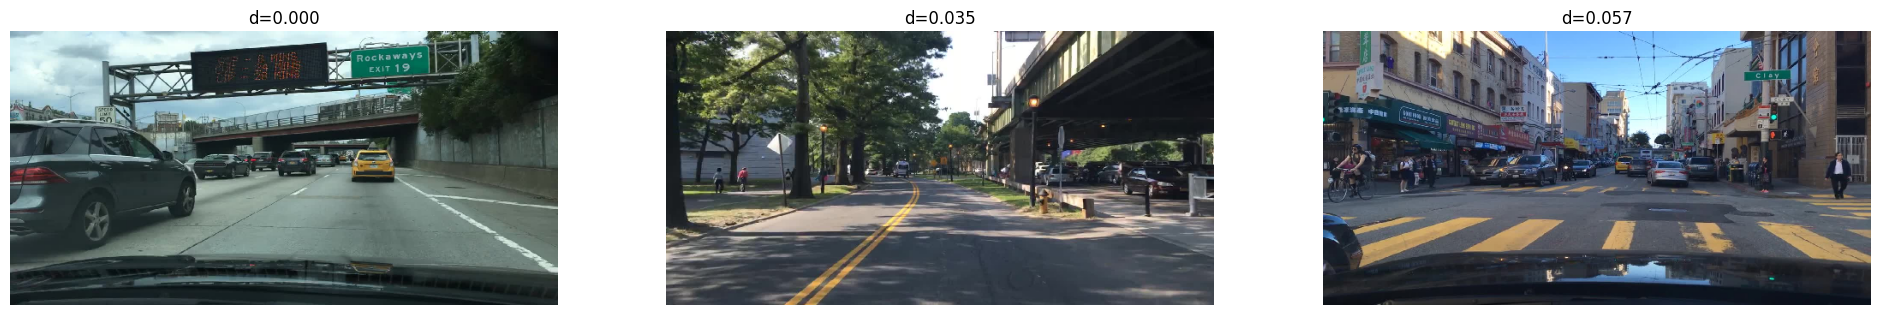

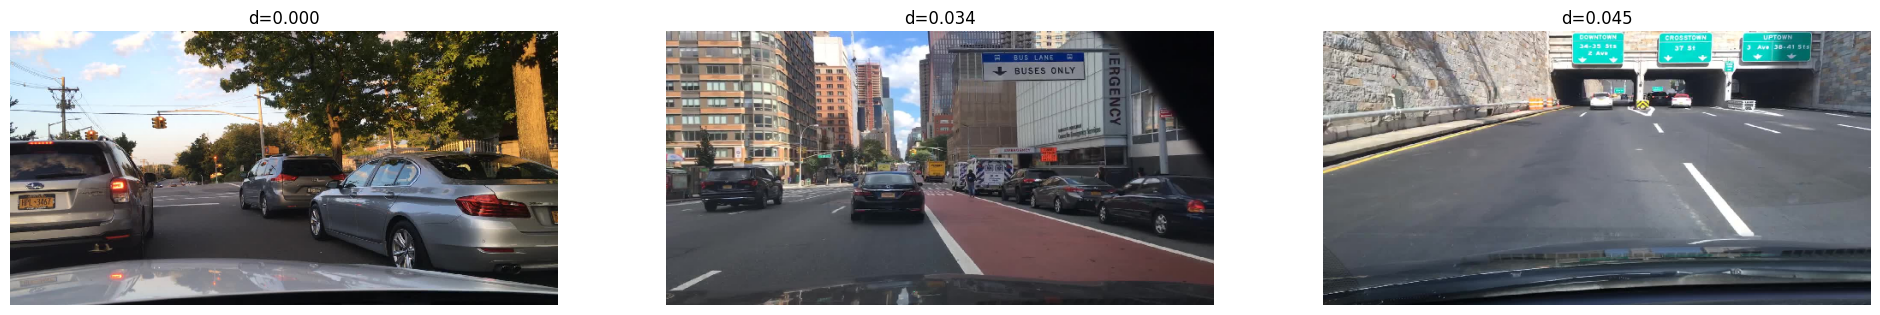

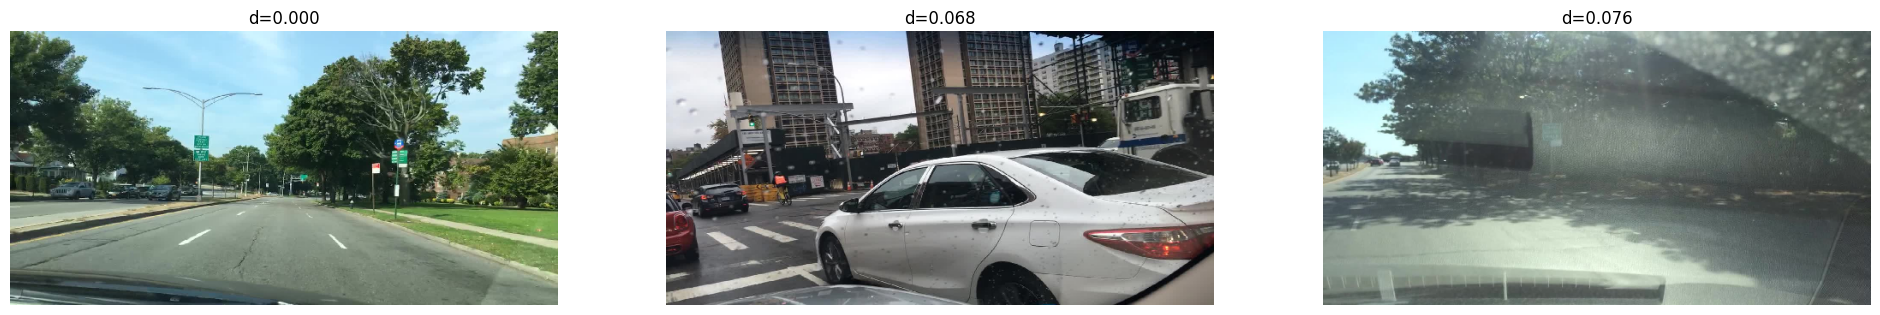

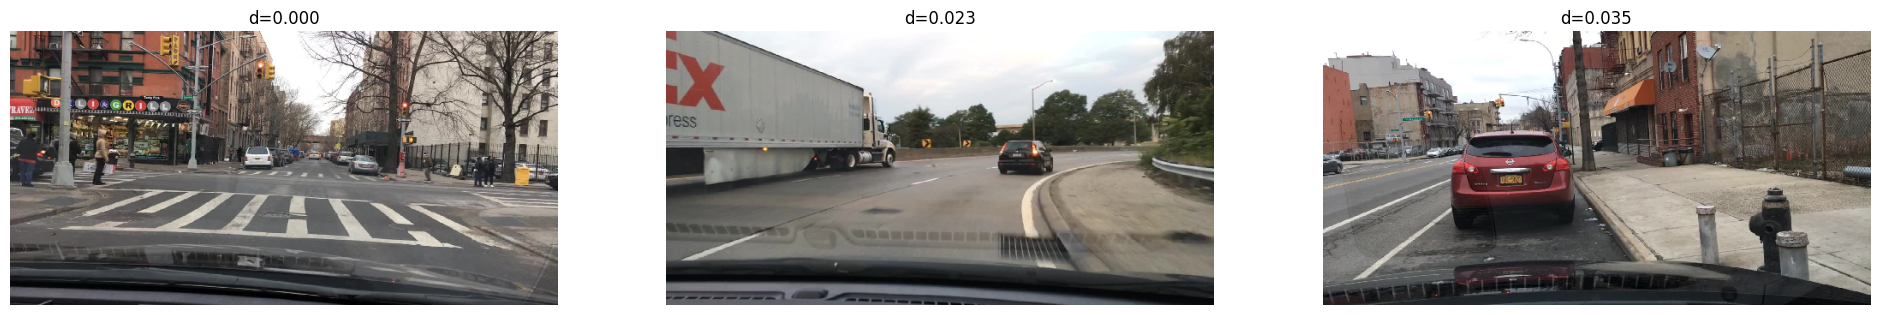

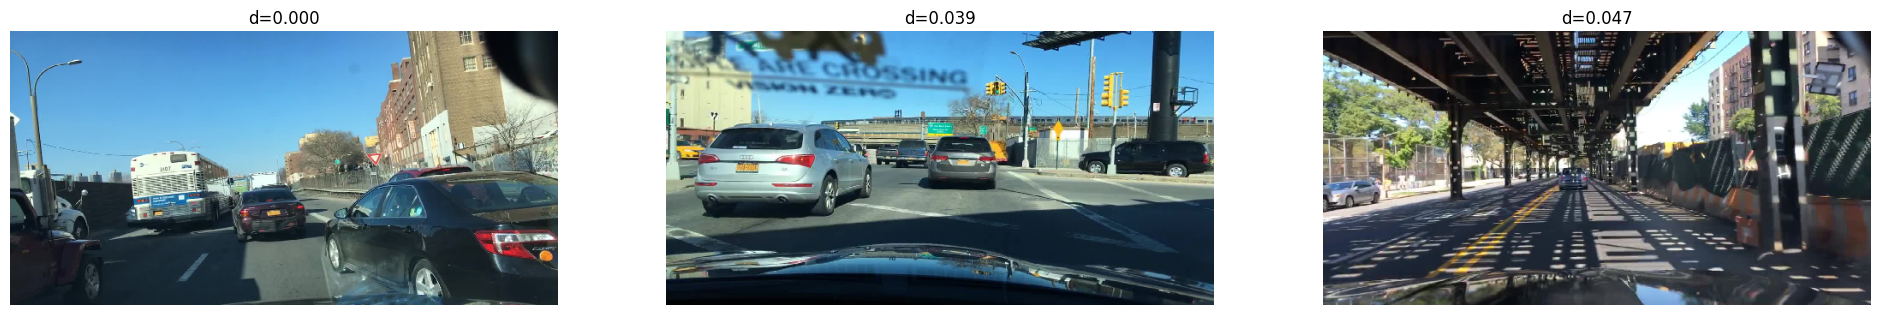

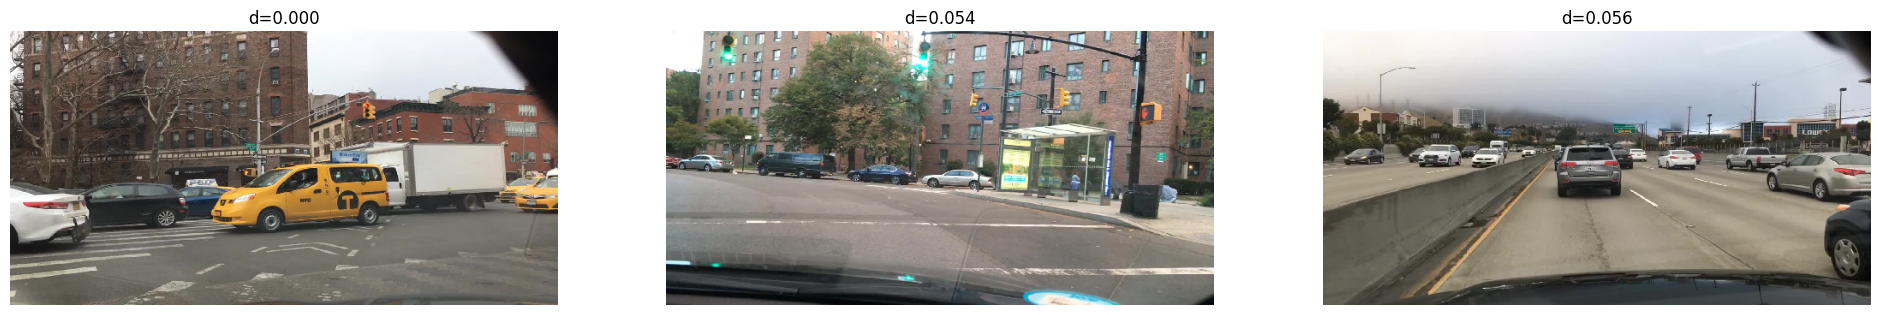

In [18]:
plot_knn_examples(embeddings, filenames)

## t-SNE plot
- Another common way to visualize the features learned by model is [t-SNE](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf).
- t-SNE helps project samples of higher dimensional space, to 2D space, which can be easily plotted for more intuition
- We'll first use PCA(Principal Component analysis) to reduce the embeddings space and then tSNE to visualize it

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# create objects for plotting
n_components = 64
scaler = StandardScaler()
pca = PCA(n_components=n_components)
tsne = TSNE()

# Normalize embeddings -> PCA (reduce feature dimensions)
embeddings_pca = pca.fit_transform(scaler.fit_transform(embeddings))
print(embeddings_pca.shape)

tsne_results = tsne.fit_transform(scaler.fit_transform(embeddings_pca))

import plotly.graph_objs as go
import plotly.offline as py


traceTSNE = go.Scatter(x = tsne_results[:,0], y = tsne_results[:,1],
                    mode = 'markers', showlegend = False,
    marker = dict(
        size = 8,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceTSNE]

layout = dict(title = 'TSNE (T-Distributed Stochastic Neighbour Embedding)',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= False,

             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

(3430, 64)


In [20]:
# dataDistribution = {
#     'Ambulance' : 132,
#     'Bicycle' : 1618,
#     'Bus' : 2133,
#     'Car' : 6781,
#     'Motorcycle' : 2986,
#     'Taxi' : 748,
#     'Truck' : 2033,
#     'Van' : 1111,
# }